
# Modelamiento predictivo espaciotemporal del delito en Guayaquil  
## Enfoque híbrido **SPINGARCH (estocástico)** + **XGBoost (aprendizaje automático)**

**Propósito del notebook (alineado al Diseño Metodológico del anteproyecto, secciones 8.1–8.7):**
1. Construir un **panel espaciotemporal** (Distrito × Día) con conteos (incluyendo ceros).
2. Definir una **estructura espacial** (matriz de pesos **W**) que represente interacción territorial.
3. Estimar un modelo **SPINGARCH(1,1)** para obtener la **intensidad condicional** \(\lambda_{i,t}\) (y, por ende, la volatilidad/heterocedasticidad condicional del proceso).
4. Entrenar **XGBoost** para capturar **no linealidades** e **interacciones** adicionales.
5. Integrar ambos en un **modelo híbrido** (SPINGARCH como componente generativo + XGBoost como corrector no lineal).
6. Evaluar y explicar el modelo (métricas, visualización, interpretabilidad tipo SHAP y reporte de riesgo).

> **Nota metodológica:** en este notebook, la predicción es de **1 paso adelante** (hoy) usando información observada hasta **ayer** (lags). Eso es consistente con un escenario operativo diario.


## 0. Configuración del entorno (librerías y reproducibilidad)

In [1]:

import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt

# Modelos / optimización
import xgboost as xgb
from scipy.special import gammaln
from scipy.stats import poisson
import scipy.optimize as opt

# Diagnóstico temporal
from statsmodels.graphics.tsaplots import plot_acf

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("xgboost:", xgb.__version__)


xgboost: 3.1.2


## 1. Datos y estructura espaciotemporal (Metodología 8.2)


En esta sección:

- Cargamos el archivo `data_kill_rd.csv`.
- Construimos una variable `date` combinando **Fecha Infracción** y **Hora Infracción**.
- Agregamos a resolución **diaria** y generamos un **panel completo** Distrito × Día, **incluyendo días con 0 delitos**.

Esto es clave para modelos de series temporales de conteo: si solo dejamos días con eventos, **se rompe** la dinámica temporal (aparecen "saltos" artificiales).


In [2]:

import os

# Ajusta esta ruta si tu CSV está en otra carpeta:
DATA_PATH = "data_kill_rd.csv"
if not os.path.exists(DATA_PATH):
    # fallback útil si estás corriendo en otro entorno (ej. sandbox)
    DATA_PATH = "/mnt/data/data_kill_rd.csv"

df_raw = pd.read_csv(DATA_PATH)

# 1) Parseo robusto de fecha y hora
df_raw["date"] = pd.to_datetime(
    df_raw["Fecha Infracción"].astype(str) + " " + df_raw["Hora Infracción"].astype(str),
    errors="coerce"
)

assert df_raw["date"].isna().sum() == 0, "Existen fechas/horas no parseables."

# 2) Nos quedamos con columnas mínimas necesarias para el panel
cols_keep = ["Distrito", "date", "Coord. Y Rev", "Coord. X Rev"]
df = df_raw[cols_keep].copy()

print("Filas:", len(df))
print("Distritos:", df["Distrito"].nunique())
print("Rango de fechas:", df["date"].min(), "→", df["date"].max())
df.head()


Filas: 2320
Distritos: 10
Rango de fechas: 2023-01-01 00:15:00 → 2023-12-31 22:00:00


,Distrito,date,Coord. Y Rev,Coord. X Rev
0,NUEVA PROSPERINA,2023-01-01 00:15:00,-2.12069,-79.97467
1,NUEVA PROSPERINA,2023-01-01 00:15:00,-2.12069,-79.97467
2,PORTETE,2023-01-01 06:20:00,-2.22615,-79.92311
3,ESTEROS,2023-01-01 23:20:00,-2.24438,-79.92579
4,NUEVA PROSPERINA,2023-01-02 01:00:00,-2.11749,-79.99108


In [3]:

# 3) Centroides por distrito (se usan para construir la matriz espacial W)
centroids = (
    df.groupby("Distrito")
      .agg(lat=("Coord. Y Rev", "mean"),
           lon=("Coord. X Rev", "mean"))
      .sort_index()
)

districts = centroids.index.tolist()

# 4) Panel completo Distrito × Día
date_range = pd.date_range(df["date"].dt.floor("D").min(),
                           df["date"].dt.floor("D").max(),
                           freq="D")

# Conteo diario observado (solo días con eventos)
counts = (
    df.groupby(["Distrito", df["date"].dt.floor("D")]).size()
      .rename("crime_count")
      .reset_index()
      .rename(columns={"date": "date"})
)

panel = (
    pd.MultiIndex.from_product([districts, date_range], names=["Distrito", "date"])
      .to_frame(index=False)
      .merge(counts, on=["Distrito", "date"], how="left")
      .merge(centroids.reset_index(), on="Distrito", how="left")
)

panel["crime_count"] = panel["crime_count"].fillna(0).astype(int)
panel = panel.sort_values(["Distrito", "date"]).reset_index(drop=True)

panel.head(), panel.shape


(       Distrito       date  crime_count       lat       lon
 0  9 DE OCTUBRE 2023-01-01            0 -2.208666 -79.90412
 1  9 DE OCTUBRE 2023-01-02            0 -2.208666 -79.90412
 2  9 DE OCTUBRE 2023-01-03            0 -2.208666 -79.90412
 3  9 DE OCTUBRE 2023-01-04            0 -2.208666 -79.90412
 4  9 DE OCTUBRE 2023-01-05            0 -2.208666 -79.90412,
 (3650, 5))

In [4]:

# 5) Features temporales básicas
panel["day"] = panel["date"].dt.day
panel["month"] = panel["date"].dt.month
panel["dow"] = panel["date"].dt.dayofweek
panel["is_weekend"] = panel["dow"].isin([5, 6]).astype(int)
panel["t"] = (panel["date"] - panel["date"].min()).dt.days

# 6) Lags (memoria criminal). Puedes ampliar a 14/21 si te interesa.
LAGS = [1, 2, 3, 7]
for lag in LAGS:
    panel[f"lag_{lag}"] = panel.groupby("Distrito")["crime_count"].shift(lag)

panel[["Distrito", "date", "crime_count"] + [f"lag_{l}" for l in LAGS]].head(12)


,Distrito,date,crime_count,lag_1,lag_2,lag_3,lag_7
0,9 DE OCTUBRE,2023-01-01,0,NaN,NaN,NaN,NaN
1,9 DE OCTUBRE,2023-01-02,0,0.0,NaN,NaN,NaN
2,9 DE OCTUBRE,2023-01-03,0,0.0,0.0,NaN,NaN
3,9 DE OCTUBRE,2023-01-04,0,0.0,0.0,0.0,NaN
4,9 DE OCTUBRE,2023-01-05,0,0.0,0.0,0.0,NaN
5,9 DE OCTUBRE,2023-01-06,0,0.0,0.0,0.0,NaN
6,9 DE OCTUBRE,2023-01-07,1,0.0,0.0,0.0,NaN
7,9 DE OCTUBRE,2023-01-08,0,1.0,0.0,0.0,0.0
8,9 DE OCTUBRE,2023-01-09,0,0.0,1.0,0.0,0.0
9,9 DE OCTUBRE,2023-01-10,1,0.0,0.0,1.0,0.0


## 2. Exploración y diagnóstico espaciotemporal (Metodología 8.1 y 8.3)


Antes de modelar, conviene **demostrar empíricamente**:

- Dependencia temporal (autocorrelación).
- Dependencia espacial (estructura de vecindad).

Esto justifica el uso de un modelo tipo **SPINGARCH** (que incorpora ambos mecanismos).


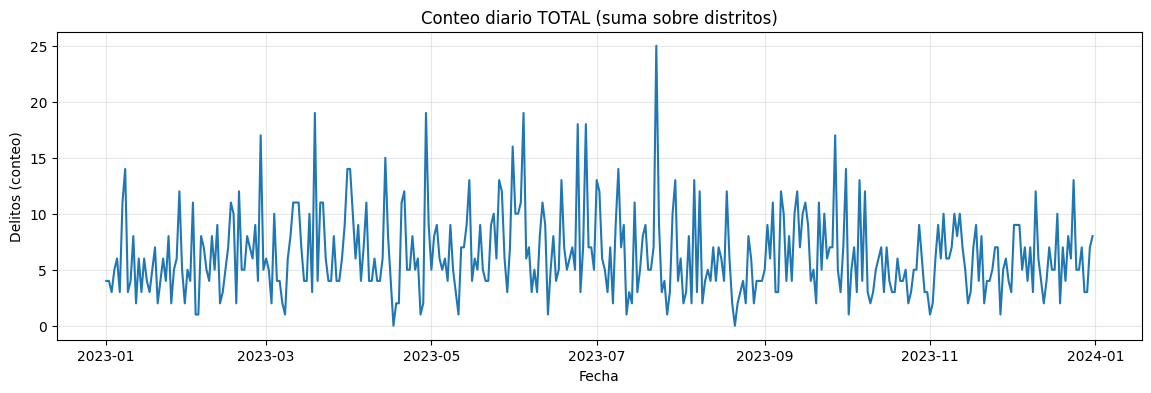

<Figure size 1000x400 with 0 Axes>

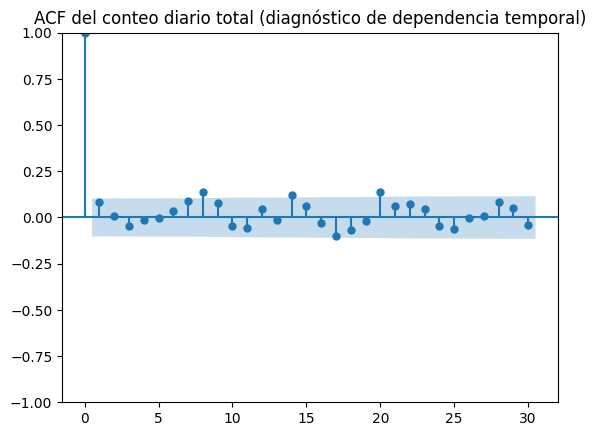

In [5]:

# Serie total (suma sobre distritos) para visualizar tendencia y picos
series_total = panel.groupby("date")["crime_count"].sum()

plt.figure(figsize=(14, 4))
plt.plot(series_total.index, series_total.values)
plt.title("Conteo diario TOTAL (suma sobre distritos)")
plt.xlabel("Fecha")
plt.ylabel("Delitos (conteo)")
plt.grid(alpha=0.3)
plt.show()

# Autocorrelación (ACF) del total
plt.figure(figsize=(10, 4))
plot_acf(series_total, lags=30)
plt.title("ACF del conteo diario total (diagnóstico de dependencia temporal)")
plt.show()


### 2.1 Construcción de la estructura espacial W (k-NN sobre centroides)


Como no siempre se dispone de un shapefile de polígonos, una alternativa estándar es construir vecindad por:

- **k-vecinos más cercanos (k-NN)** según distancia geográfica entre centroides.
- Pesos **inversos a la distancia**, normalizados por filas.

Esto nos da una matriz **W** con filas que suman 1, interpretables como "promedio ponderado de vecinos".


Suma por fila (debe ser 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


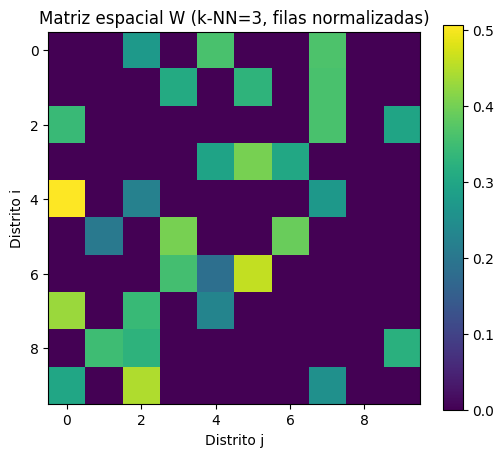

0 → 9 DE OCTUBRE
1 → CEIBOS
2 → ESTEROS
3 → FLORIDA
4 → MODELO
5 → NUEVA PROSPERINA
6 → PASCUALES
7 → PORTETE
8 → PROGRESO
9 → SUR


In [6]:

from sklearn.metrics.pairwise import haversine_distances

coords = centroids[["lat", "lon"]].to_numpy()
coords_rad = np.radians(coords)

# Distancia haversine (km)
dist_km = haversine_distances(coords_rad, coords_rad) * 6371.0

def build_knn_weights(dist_matrix, k=3, eps=1e-6):
    n = dist_matrix.shape[0]
    W = np.zeros((n, n), dtype=float)
    for i in range(n):
        nn = np.argsort(dist_matrix[i])[1:k+1]  # excluye self
        w = 1.0 / (dist_matrix[i, nn] + eps)
        w = w / w.sum()
        W[i, nn] = w
    return W

K_NEIGHBORS = 3
W = build_knn_weights(dist_km, k=K_NEIGHBORS)

# Validación: filas suman 1
print("Suma por fila (debe ser 1):", np.round(W.sum(axis=1), 5))

# Visualización rápida de W
plt.figure(figsize=(6, 5))
plt.imshow(W)
plt.title(f"Matriz espacial W (k-NN={K_NEIGHBORS}, filas normalizadas)")
plt.xlabel("Distrito j")
plt.ylabel("Distrito i")
plt.colorbar()
plt.show()

# Etiquetas para referencia
for i, d in enumerate(districts):
    print(i, "→", d)


### 2.2 (Opcional) Moran's I simple para evidenciar autocorrelación espacial


Aquí calculamos un **Moran's I** básico (sin inferencia por permutación), para tener un indicador exploratorio de autocorrelación espacial.

**Interpretación:**
- Moran's I > 0 sugiere **agrupamiento** (distritos con valores similares próximos).  
- Moran's I < 0 sugiere patrón tipo tablero (**dispersión**).  
- Moran's I ≈ 0 sugiere aleatoriedad espacial.


Moran's I (promedio por distrito): -0.1095


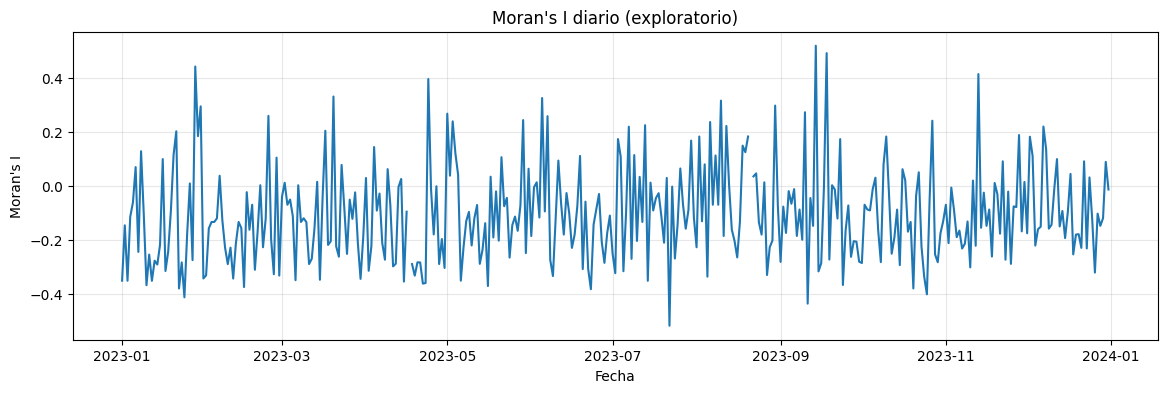

In [7]:

def morans_I(x, W):
    x = np.asarray(x, dtype=float)
    n = len(x)
    x_bar = x.mean()
    z = x - x_bar

    S0 = W.sum()
    num = 0.0
    for i in range(n):
        for j in range(n):
            num += W[i, j] * z[i] * z[j]
    den = (z**2).sum()
    if den == 0:
        return np.nan
    return (n / S0) * (num / den)

# Ejemplo: Moran's I en la media de conteos por distrito
avg_by_dist = panel.groupby("Distrito")["crime_count"].mean().loc[districts].values
I_avg = morans_I(avg_by_dist, W)
print("Moran's I (promedio por distrito):", round(I_avg, 4))

# Moran's I por día (serie temporal de autocorrelación espacial)
Y_mat = panel.pivot(index="date", columns="Distrito", values="crime_count").loc[date_range, districts].to_numpy()
I_daily = [morans_I(Y_mat[t], W) for t in range(len(date_range))]

plt.figure(figsize=(14, 4))
plt.plot(date_range, I_daily)
plt.title("Moran's I diario (exploratorio)")
plt.xlabel("Fecha")
plt.ylabel("Moran's I")
plt.grid(alpha=0.3)
plt.show()


## 3. Modelamiento estadístico: SPINGARCH (Metodología 8.4)


### 3.1 Definición del SPINGARCH(1,1) (forma base)

Para cada distrito \(i\) y día \(t\):

\[
Y_{i,t}\,|\,\mathcal{F}_{t-1} \sim \text{Poisson}(\lambda_{i,t})
\]

y la intensidad condicional evoluciona como:

\[
\lambda_{i,t} = \omega + \alpha Y_{i,t-1} + \beta \lambda_{i,t-1} + \gamma \sum_{j=1}^N w_{ij} Y_{j,t-1}.
\]

**Interpretación criminológica/estadística:**
- \(\omega\): nivel base (intensidad mínima).
- \(\alpha\): “shock” local de corto plazo (memoria criminal inmediata).
- \(\beta\): persistencia/inercia de la intensidad (memoria suave).
- \(\gamma\): contagio espacial (spillover) desde distritos vecinos (según W).

**Volatilidad/heterocedasticidad condicional:**
- En Poisson, \(\text{Var}(Y_{i,t}|\mathcal{F}_{t-1})=\lambda_{i,t}\), así que \(\lambda_{i,t}\) actúa como **media y varianza condicional**.  
- La dinámica autorregresiva hace que \(\lambda\) suba y baje con “clusters”, capturando **volatilidad** en el tiempo y el espacio.


In [8]:

def spingarch_filter(Y, W, omega, alpha, beta, gamma, eps=1e-6):
    '''
    Filtro SPINGARCH(1,1) para obtener lambdas condicionales.

    Y: (T, N) conteos
    W: (N, N) matriz espacial, filas normalizadas
    '''
    Y = np.asarray(Y, dtype=float)
    T, N = Y.shape
    Lam = np.zeros((T, N), dtype=float)

    # Inicialización: media histórica por distrito
    Lam[0] = np.maximum(Y.mean(axis=0), eps)

    for t in range(1, T):
        spatial_term = W @ Y[t-1]
        Lam[t] = omega + alpha * Y[t-1] + beta * Lam[t-1] + gamma * spatial_term
        Lam[t] = np.maximum(Lam[t], eps)  # evita log(0)
    return Lam

def spingarch_negloglik(params, Y, W):
    '''
    -log verosimilitud Poisson para SPINGARCH(1,1), con restricciones suaves.
    '''
    omega, alpha, beta, gamma = params

    # Restricciones básicas
    if omega <= 0 or alpha < 0 or beta < 0 or gamma < 0:
        return 1e12
    # Condición de estabilidad (heurística) para evitar explosión
    if (alpha + beta + gamma) >= 0.999:
        return 1e12

    Lam = spingarch_filter(Y, W, omega, alpha, beta, gamma)

    # log-likelihood Poisson: y log lam - lam - log(y!)
    ll = (Y * np.log(Lam) - Lam - gammaln(Y + 1)).sum()
    return -ll

# Matriz Y (T x N) ordenada por fecha y distrito
Y = panel.pivot(index="date", columns="Distrito", values="crime_count").loc[date_range, districts].to_numpy()
print("Y shape:", Y.shape)


Y shape: (365, 10)


### 3.2 Estimación por máxima verosimilitud


Estimamos \((\omega,\alpha,\beta,\gamma)\) maximizando la verosimilitud (equivale a minimizar el negativo).

> **Importante:** es una implementación “operativa” para un anteproyecto.  
En investigación avanzada se discuten otras variantes (binomial negativa, covariables, bayesiano, etc.).  
Pero esta versión ya captura el núcleo: **conteo + memoria temporal + contagio espacial**.


In [9]:

# Inicialización razonable (puedes ajustarla)
x0 = np.array([0.10, 0.20, 0.60, 0.10])

bounds = [
    (1e-6, None),  # omega > 0
    (0.0, 0.999),  # alpha >= 0
    (0.0, 0.999),  # beta >= 0
    (0.0, 0.999),  # gamma >= 0
]

res = opt.minimize(
    spingarch_negloglik,
    x0=x0,
    args=(Y, W),
    method="L-BFGS-B",
    bounds=bounds,
    options={"maxiter": 500}
)

print("Converge:", res.success)
print("Mensaje:", res.message)

omega, alpha, beta, gamma = res.x
print("\nParámetros estimados (SPINGARCH):")
print(f"omega = {omega:.4f}")
print(f"alpha = {alpha:.4f}")
print(f"beta  = {beta:.4f}")
print(f"gamma = {gamma:.4f}")
print(f"alpha+beta+gamma = {alpha+beta+gamma:.4f}  (debe ser < 1 para estabilidad)")

Lam = spingarch_filter(Y, W, omega, alpha, beta, gamma)


Converge: True
Mensaje: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH

Parámetros estimados (SPINGARCH):
omega = 0.0720
alpha = 0.2278
beta  = 0.6741
gamma = 0.0331
alpha+beta+gamma = 0.9350  (debe ser < 1 para estabilidad)


### 3.3 Intensidad condicional y volatilidad

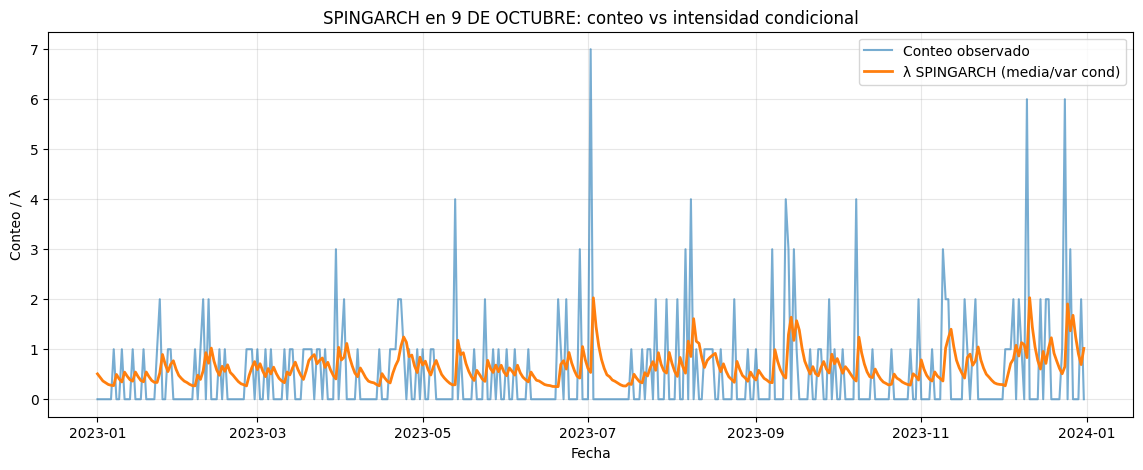

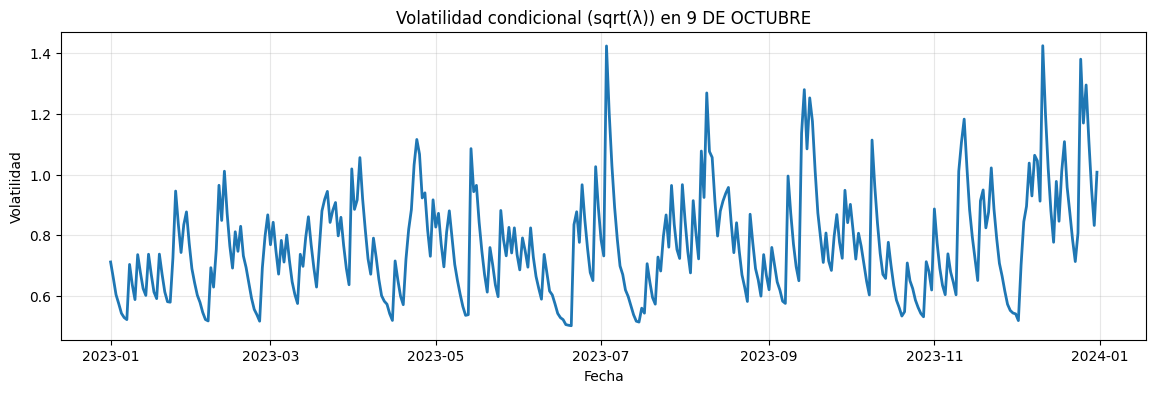

In [10]:

# Convertimos Lambda a DataFrame largo y lo unimos al panel
lam_df = pd.DataFrame(Lam, index=date_range, columns=districts).reset_index().rename(columns={"index": "date"})
lam_long = lam_df.melt(id_vars="date", var_name="Distrito", value_name="lambda_spingarch")

panel = panel.merge(lam_long, on=["Distrito", "date"], how="left")

# Volatilidad simple (en Poisson, var cond = lambda). Tomamos sqrt(lambda) como "volatilidad".
panel["volatility_sp"] = np.sqrt(panel["lambda_spingarch"])

# Gráfico de ejemplo en un distrito
example_dist = districts[0]
subset = panel[panel["Distrito"] == example_dist]

plt.figure(figsize=(14, 5))
plt.plot(subset["date"], subset["crime_count"], label="Conteo observado", alpha=0.6)
plt.plot(subset["date"], subset["lambda_spingarch"], label="λ SPINGARCH (media/var cond)", linewidth=2)
plt.title(f"SPINGARCH en {example_dist}: conteo vs intensidad condicional")
plt.xlabel("Fecha")
plt.ylabel("Conteo / λ")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(subset["date"], subset["volatility_sp"], label="Volatilidad = sqrt(λ)", linewidth=2)
plt.title(f"Volatilidad condicional (sqrt(λ)) en {example_dist}")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.grid(alpha=0.3)
plt.show()


### 3.4 Feature espacial: rezago espacial (promedio ponderado de vecinos)

In [11]:

# rezago espacial 1: W @ y_{t-1}
spatial_lag = np.zeros_like(Y, dtype=float)
spatial_lag[0] = np.nan
for t in range(1, Y.shape[0]):
    spatial_lag[t] = W @ Y[t-1]

spatial_df = pd.DataFrame(spatial_lag, index=date_range, columns=districts).reset_index().rename(columns={"index":"date"})
spatial_long = spatial_df.melt(id_vars="date", var_name="Distrito", value_name="spatial_lag1")

panel = panel.merge(spatial_long, on=["Distrito","date"], how="left")
panel["spatial_lag1"] = panel["spatial_lag1"].fillna(0)

panel[["Distrito","date","crime_count","spatial_lag1","lambda_spingarch"]].head(10)


,Distrito,date,crime_count,spatial_lag1,lambda_spingarch
0,9 DE OCTUBRE,2023-01-01,0,0.000000,0.506849
1,9 DE OCTUBRE,2023-01-02,0,0.638301,0.434777
2,9 DE OCTUBRE,2023-01-03,0,0.000000,0.365090
3,9 DE OCTUBRE,2023-01-04,0,0.364697,0.330166
4,9 DE OCTUBRE,2023-01-05,0,0.000000,0.294567
5,9 DE OCTUBRE,2023-01-06,0,0.273604,0.279613
6,9 DE OCTUBRE,2023-01-07,1,0.361699,0.272444
7,9 DE OCTUBRE,2023-01-08,0,0.361699,0.495451
8,9 DE OCTUBRE,2023-01-09,0,0.000000,0.405992
9,9 DE OCTUBRE,2023-01-10,1,0.000000,0.345685


## 4. Modelamiento predictivo con XGBoost (Metodología 8.5)


### 4.1 ¿Qué aprende XGBoost aquí?

XGBoost (Gradient Boosting de árboles) aprende una función:

\[
\hat{y}_{i,t} = f(\text{lags}, \text{espacio}, \text{tiempo}, \ldots)
\]

Usaremos `objective="count:poisson"` porque nuestra variable respuesta es un conteo.

**Idea práctica:**
- Los **lags** capturan memoria temporal.
- `spatial_lag1` captura contagio espacial (de manera no paramétrica).
- Variables de calendario capturan estacionalidad (día/mes/día de semana).
- Coordenadas (centroides) aportan estructura espacial suave.


### 4.2 Explicación de hiperparámetros clave de XGBoost


- `n_estimators`: número de árboles (más árboles → más capacidad, pero mayor riesgo de sobreajuste si no regularizas).
- `learning_rate` (η): tamaño del paso; típico 0.01–0.1. Más bajo → requiere más árboles, pero generaliza mejor.
- `max_depth`: profundidad máxima del árbol; controla complejidad e interacciones.
- `subsample`: fracción de filas para cada árbol (bagging); ayuda a generalizar.
- `colsample_bytree`: fracción de variables por árbol; reduce correlación entre árboles.
- `min_child_weight`: mínimo “peso” en hojas; evita hojas con pocos datos (regulariza).
- `reg_lambda` (L2) y `reg_alpha` (L1): regularización.
- `objective="count:poisson"`: el modelo produce una **intensidad** \(\hat{\lambda}\) y predice \(\mathbb{E}[Y]=\hat{\lambda}\).


In [12]:

# Dataset final para ML: eliminamos filas donde no existen lags (primeros días)
feature_cols = [
    "spatial_lag1",
    "lag_1","lag_2","lag_3","lag_7",
    "lat","lon",
    "day","month","dow","is_weekend","t"
]

panel_ml = panel.dropna(subset=[f"lag_{l}" for l in LAGS]).copy()

# One-hot para el distrito (efecto fijo no lineal)
X = pd.get_dummies(panel_ml[feature_cols + ["Distrito"]], columns=["Distrito"], drop_first=False)
y = panel_ml["crime_count"].astype(float)

# Para el híbrido, guardamos también lambda_spingarch y base_margin = log(lambda)
panel_ml["base_margin_sp"] = np.log(panel_ml["lambda_spingarch"].values + 1e-6)

print("X shape:", X.shape, " | y mean:", y.mean(), " | y max:", y.max())
X.head()


X shape: (3580, 22)  | y mean: 0.6379888268156425  | y max: 18.0


,spatial_lag1,lag_1,lag_2,lag_3,lag_7,lat,lon,day,month,dow,...,Distrito_9 DE OCTUBRE,Distrito_CEIBOS,Distrito_ESTEROS,Distrito_FLORIDA,Distrito_MODELO,Distrito_NUEVA PROSPERINA,Distrito_PASCUALES,Distrito_PORTETE,Distrito_PROGRESO,Distrito_SUR
7,0.361699,1.0,0.0,0.0,0.0,-2.208666,-79.90412,8,1,6,...,True,False,False,False,False,False,False,False,False,False
8,0.000000,0.0,1.0,0.0,0.0,-2.208666,-79.90412,9,1,0,...,True,False,False,False,False,False,False,False,False,False
9,0.000000,0.0,0.0,1.0,0.0,-2.208666,-79.90412,10,1,1,...,True,False,False,False,False,False,False,False,False,False
10,0.273604,1.0,0.0,0.0,0.0,-2.208666,-79.90412,11,1,2,...,True,False,False,False,False,False,False,False,False,False
11,0.635303,0.0,1.0,0.0,0.0,-2.208666,-79.90412,12,1,3,...,True,False,False,False,False,False,False,False,False,False


### 4.3 Split temporal (train/test) y modelo XGBoost base

In [13]:

# Split simple: entrenamos hasta el 2023-10-31 y testeamos 2023-11-01 en adelante
cutoff = pd.Timestamp("2023-11-01")
train_mask = panel_ml["date"] < cutoff
test_mask = ~train_mask

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

params = dict(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="count:poisson",
    reg_lambda=1.0,
    min_child_weight=1,
    random_state=RANDOM_STATE,
    n_jobs=4
)

model_xgb = xgb.XGBRegressor(**params)
model_xgb.fit(X_train, y_train)

pred_xgb = model_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
mae_xgb = mean_absolute_error(y_test, pred_xgb)

print("XGBoost (base) - Test")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE : {mae_xgb:.4f}")


XGBoost (base) - Test
RMSE: 1.0417
MAE : 0.6493


## 5. Integración híbrida SPINGARCH + XGBoost (Metodología 8.6)


### 5.1 Estrategia híbrida recomendada: **SPINGARCH como prior (base_margin)**

Una manera elegante y coherente de hibridar es:

1. **SPINGARCH** produce \(\lambda^{(sp)}_{i,t}\) (intensidad condicional).
2. Convertimos a margen (escala log):  \(m^{(sp)}_{i,t} = \log(\lambda^{(sp)}_{i,t})\).
3. Entrenamos XGBoost para aprender una corrección \(g(x_{i,t})\):

\[
\log(\lambda^{(hyb)}_{i,t}) = m^{(sp)}_{i,t} + g(x_{i,t})
\Rightarrow
\lambda^{(hyb)}_{i,t} = \lambda^{(sp)}_{i,t} \, \exp(g(x_{i,t})).
\]

**Ventaja:** el componente estocástico (SPINGARCH) aporta la estructura generativa (memoria+espacio), y XGBoost solo modela el **residuo no lineal**.


In [14]:

# Base margins
bm_train = panel_ml.loc[train_mask, "base_margin_sp"].values
bm_test  = panel_ml.loc[test_mask, "base_margin_sp"].values

model_hybrid = xgb.XGBRegressor(**params)
model_hybrid.fit(X_train, y_train, base_margin=bm_train)

pred_hybrid = model_hybrid.predict(X_test, base_margin=bm_test)

rmse_h = np.sqrt(mean_squared_error(y_test, pred_hybrid))
mae_h = mean_absolute_error(y_test, pred_hybrid)

print("Híbrido (SPINGARCH prior + XGBoost) - Test")
print(f"RMSE: {rmse_h:.4f}")
print(f"MAE : {mae_h:.4f}")


Híbrido (SPINGARCH prior + XGBoost) - Test
RMSE: 1.0309
MAE : 0.6438


### 5.2 Comparación visual (un distrito de ejemplo)

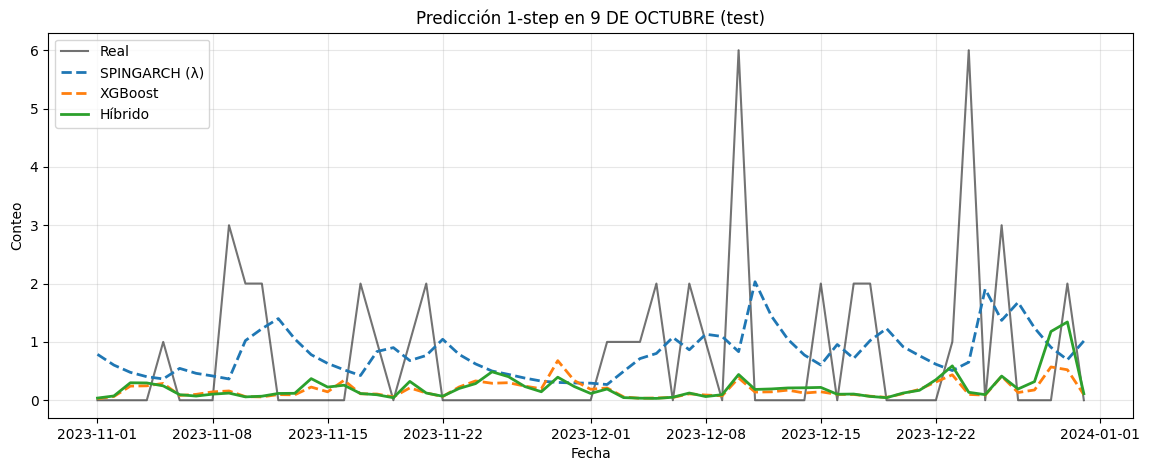

In [15]:

# Unimos predicciones al panel de test para graficar
test_view = panel_ml.loc[test_mask, ["date","Distrito","crime_count","lambda_spingarch"]].copy()
test_view["pred_xgb"] = pred_xgb
test_view["pred_hybrid"] = pred_hybrid

example_dist = districts[0]
sub = test_view[test_view["Distrito"] == example_dist]

plt.figure(figsize=(14, 5))
plt.plot(sub["date"], sub["crime_count"], label="Real", color="black", alpha=0.55)
plt.plot(sub["date"], sub["lambda_spingarch"], label="SPINGARCH (λ)", linestyle="--", linewidth=2)
plt.plot(sub["date"], sub["pred_xgb"], label="XGBoost", linestyle="--", linewidth=2)
plt.plot(sub["date"], sub["pred_hybrid"], label="Híbrido", linewidth=2)

plt.title(f"Predicción 1-step en {example_dist} (test)")
plt.xlabel("Fecha")
plt.ylabel("Conteo")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 6. Evaluación robusta e interpretabilidad (Metodología 8.7)


### 6.1 Métricas adicionales para conteos (Poisson Deviance)

Además de RMSE/MAE, es útil reportar una métrica coherente con conteos (deviance Poisson).  
Menor es mejor.


In [16]:

def poisson_deviance(y_true, mu_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    mu = np.asarray(mu_pred, dtype=float)
    mu = np.maximum(mu, eps)
    mask = y_true > 0
    term = np.zeros_like(y_true, dtype=float)
    term[mask] = y_true[mask] * np.log(y_true[mask] / mu[mask])
    dev = 2 * np.sum(term - (y_true - mu))
    return dev / len(y_true)

dev_xgb = poisson_deviance(y_test, pred_xgb)
dev_h   = poisson_deviance(y_test, pred_hybrid)
dev_sp  = poisson_deviance(y_test, test_view["lambda_spingarch"].values)

print("Poisson deviance promedio (test) — menor es mejor")
print(f"SPINGARCH: {dev_sp:.4f}")
print(f"XGBoost  : {dev_xgb:.4f}")
print(f"Híbrido  : {dev_h:.4f}")


Poisson deviance promedio (test) — menor es mejor
SPINGARCH: 1.3330
XGBoost  : 1.7870
Híbrido  : 1.7189


### 6.2 Importancia de variables (XGBoost)

<Figure size 1000x600 with 0 Axes>

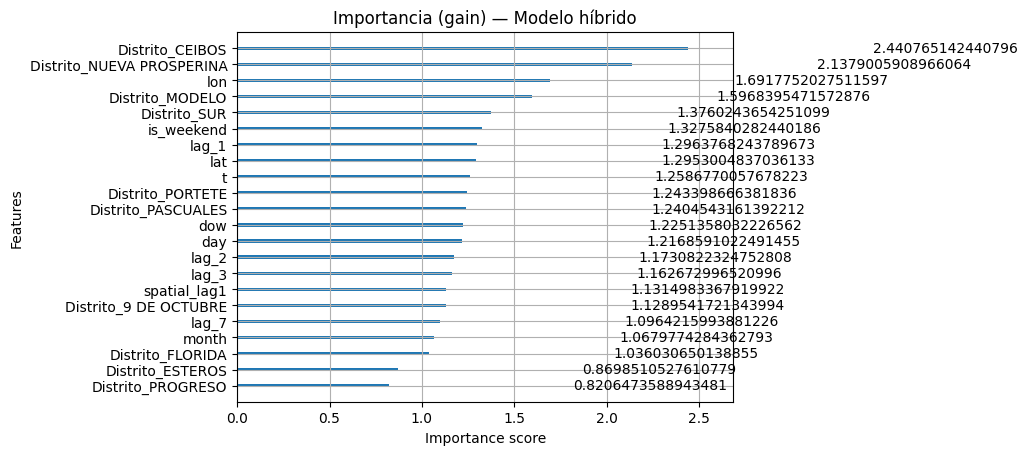

In [17]:

plt.figure(figsize=(10, 6))
xgb.plot_importance(model_hybrid, importance_type="gain", title="Importancia (gain) — Modelo híbrido")
plt.show()


### 6.3 Interpretabilidad tipo SHAP sin librería externa (TreeSHAP interno de XGBoost)


XGBoost puede calcular contribuciones tipo **TreeSHAP** directamente con `pred_contribs=True`.

- Global: media de |contribución| por variable.
- Local: contribuciones para un caso particular.


Top 15 variables por |contribución| promedio:
BIAS                         0.615947
t                            0.500602
lag_1                        0.370970
lon                          0.198816
lag_2                        0.192414
dow                          0.164722
spatial_lag1                 0.143607
day                          0.131558
lat                          0.121482
Distrito_NUEVA PROSPERINA    0.080303
Distrito_CEIBOS              0.078423
lag_3                        0.074357
lag_7                        0.055048
Distrito_FLORIDA             0.043791
Distrito_MODELO              0.042870
dtype: float32


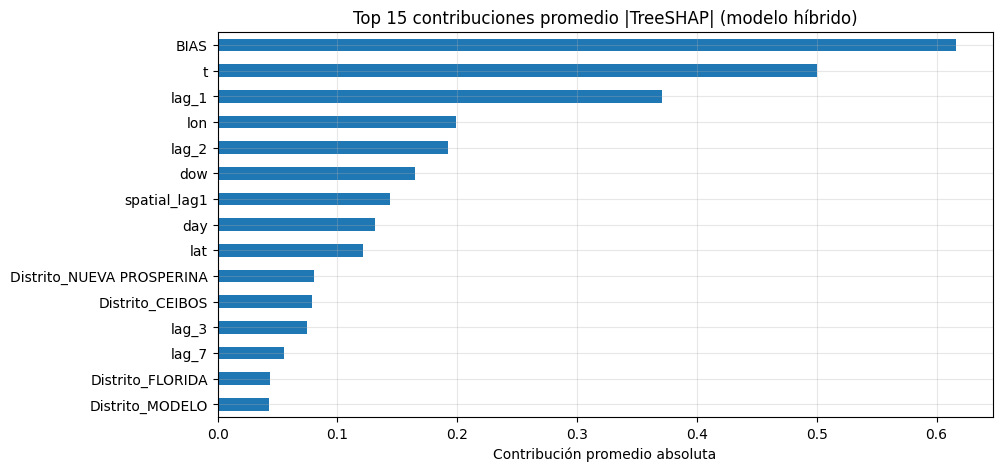


Caso seleccionado (alto riesgo según el modelo):
date                2023-12-24 00:00:00
Distrito                        PORTETE
crime_count                           0
lambda_spingarch               0.875043
pred_hybrid                    1.783549
Name: 2912, dtype: object

Top contribuciones (local):
lag_1                        0.499341
dow                          0.291084
t                           -0.208561
BIAS                        -0.197127
Distrito_PORTETE             0.089913
lon                          0.077190
Distrito_NUEVA PROSPERINA   -0.055219
lat                         -0.039846
spatial_lag1                -0.039494
is_weekend                   0.038575
month                        0.034635
lag_2                        0.030481
dtype: float32


In [18]:

# DMatrix para obtener contribuciones (TreeSHAP interno)
dtest = xgb.DMatrix(X_test)
dtest.set_base_margin(bm_test)

contrib = model_hybrid.get_booster().predict(dtest, pred_contribs=True)  # (n, p+1) incluye bias
feature_names = list(X_test.columns) + ["BIAS"]

# Importancia global: media |SHAP|
mean_abs = np.abs(contrib).mean(axis=0)
imp = pd.Series(mean_abs, index=feature_names).sort_values(ascending=False)

print("Top 15 variables por |contribución| promedio:")
print(imp.head(15))

plt.figure(figsize=(10, 5))
imp.head(15).iloc[::-1].plot(kind="barh")
plt.title("Top 15 contribuciones promedio |TreeSHAP| (modelo híbrido)")
plt.xlabel("Contribución promedio absoluta")
plt.grid(alpha=0.3)
plt.show()

# Explicación local: caso con predicción alta
idx = int(np.argmax(pred_hybrid))
row_info = test_view.iloc[idx][["date","Distrito","crime_count","lambda_spingarch","pred_hybrid"]]
print("\nCaso seleccionado (alto riesgo según el modelo):")
print(row_info)

local = pd.Series(contrib[idx], index=feature_names).sort_values(key=np.abs, ascending=False)
print("\nTop contribuciones (local):")
print(local.head(12))


## 7. Reporte operativo de riesgo (probabilidades Poisson)


Un resultado que suele impresionar es convertir la **media esperada** \(\hat\lambda\) en probabilidades:

- \(P(Y=0)\): prob. de “calma total” (cero delitos).
- \(P(Y>k)\): prob. de “alto riesgo” (más de k delitos).

Esto permite traducir la predicción en un **semáforo de alerta**.


In [19]:

def risk_report(expected_count, k_high=3):
    expected_count = max(float(expected_count), 1e-9)

    p0 = poisson.pmf(0, expected_count)                 # P(Y=0)
    p_high = 1 - poisson.cdf(k_high, expected_count)    # P(Y>k)

    if p_high > 0.15:
        level = "ROJA"
    elif p_high > 0.05:
        level = "AMARILLA"
    else:
        level = "VERDE"

    return {
        "lambda_pred": round(expected_count, 4),
        "P(Y=0) %": round(100*p0, 2),
        f"P(Y>{k_high}) %": round(100*p_high, 2),
        "alerta": level
    }

# Ejemplo: generar reporte para el caso seleccionado
rep = risk_report(row_info["pred_hybrid"], k_high=3)
rep


{'lambda_pred': 1.7835,
 'P(Y=0) %': np.float64(16.8),
 'P(Y>3) %': np.float64(10.61),
 'alerta': 'AMARILLA'}

## 8. Función de predicción (plantilla para producción / demo)


Esta función muestra cómo armar una predicción para un **día y distrito** cuando ya tienes:

- lags,
- spatial_lag1,
- variables de calendario,
- y el prior SPINGARCH (base_margin).

En un sistema real, esto se automatiza en un pipeline que cada noche actualiza lags y recalcula \(\lambda\).


In [20]:

def build_features_single(distrito, date, panel_full, feature_cols):
    '''
    Construye una fila de features para (distrito, date) a partir del panel completo.
    Requiere que el panel ya tenga lags, spatial_lag1, y variables temporales.
    '''
    row = panel_full[(panel_full["Distrito"] == distrito) & (panel_full["date"] == date)].copy()
    if len(row) != 1:
        raise ValueError("No se encontró exactamente 1 fila para ese (distrito, date).")

    X_row = pd.get_dummies(row[feature_cols + ["Distrito"]], columns=["Distrito"], drop_first=False)

    # Asegura columnas consistentes con X_train
    for col in X_train.columns:
        if col not in X_row.columns:
            X_row[col] = 0
    X_row = X_row[X_train.columns]
    return X_row, row["base_margin_sp"].values

# Demo: tomamos el último día disponible del panel_ml
demo_date = panel_ml["date"].max()
demo_dist = districts[0]

X_row, bm_row = build_features_single(
    demo_dist,
    demo_date,
    panel_ml,
    feature_cols
)

pred_demo = model_hybrid.predict(X_row, base_margin=bm_row)[0]
print("Predicción híbrida:", pred_demo)
print("Reporte:", risk_report(pred_demo, k_high=3))


Predicción híbrida: 0.111827604
Reporte: {'lambda_pred': 0.1118, 'P(Y=0) %': np.float64(89.42), 'P(Y>3) %': np.float64(0.0), 'alerta': 'VERDE'}



## 9. Ideas para “subir nivel” (si quieres impresionar más)

1. **Validación walk-forward real**: simular el escenario donde cada día se observa el conteo real y se actualizan lags + λ.
2. **Sobredispersión severa**: cambiar Poisson por Binomial Negativa (NB) en el componente estocástico.
3. **Covariables urbanas**: incorporar variables exógenas (densidad, iluminación, eventos, clima, etc.).
4. **Mapa de riesgo**: si consigues shapefile de distritos, puedes mapear `pred_hybrid` como coropleta.
5. **Intervalos de predicción**: usar Poisson/NB para intervalos y cuantiles (gestión operativa).
